# **CNN for Text Classification**

### **Load dataset**

In [1]:
import os
import pandas as pd
import re
import string
import time
import matplotlib.pyplot as plt

from langid.langid import LanguageIdentifier, model
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# !git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
Updating files:  72% (8/11)
Updating files:  81% (9/11)
Updating files:  90% (10/11)
Updating files: 100% (11/11)
Updating files: 100% (11/11), done.


In [3]:
import shutil
from zipfile import ZipFile

DATA_PATH = './data' 
os.makedirs(DATA_PATH, exist_ok=True)

with ZipFile('./ntc-scv/data/data_test.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

shutil.rmtree('./ntc-scv', ignore_errors=True)

In [4]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [5]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

### **Preprocessing**

In [ ]:
# !pip install langid

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [8]:
train_df_vi, train_df_other = identify_vn(train_df)

In [9]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [10]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11184\1058621333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [11]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


### **Representation**

In [ ]:
# !pip install torchtext==0.16.0

Defaulting to user installation because normal site-packages is not writeable


In [13]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [14]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [15]:
# Define constants for special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=[PAD_TOKEN, UNK_TOKEN]  # Use constants for special tokens
)

# Set default index for unknown token
vocabulary.set_default_index(vocabulary[UNK_TOKEN])

In [16]:
# Access the padding token index
vocabulary[PAD_TOKEN]

0

In [17]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

### **Dataloader**

In [18]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary[PAD_TOKEN]
    )

    return encoded_sentences, labels

In [19]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [20]:
next(iter(train_dataloader))

(tensor([[   7,  149,  294,  ...,   92,    3, 7198],
         [  63, 1317,    4,  ...,   12,  133, 4050],
         [ 296,  174,  578,  ...,   71,   41, 2132],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
         1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
         0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
         0, 1, 1, 1, 1, 0, 0, 0]))

In [21]:
encoded_sentences, labels = next(iter(train_dataloader))

In [22]:
encoded_sentences.shape

torch.Size([376, 128])

### **Model**

In [23]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_samples = 0, 0
    losses = []
    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Clip gradient norm
        optimizer.step()

        # Update metrics
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

        # Log progress at intervals
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| Epoch {epoch:3d} | Batch {batch_idx:5d}/{len(train_dataloader):5d} | "
                f"Accuracy {total_acc / total_samples:.3f}"
            )
            total_acc, total_samples = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate(model, criterion, device, valid_dataloader):
    model.eval()
    total_acc, total_samples = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            # Update metrics
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

**TextCNN**

In [24]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes

        # Embedding layer: Converts word indices into continuous vectors (embeddings)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Create a list of convolutional layers (one for each kernel size)
        # Each convolutional layer takes the embedded word vectors as input and applies filters of size 'k'
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k, # Kernel size: different values for each convolution layer
                stride=1
            ) for k in kernel_sizes # Loop through all kernel sizes
        ])

        # Fully connected layer: Converts extracted features from convolutional layers into class predictions
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # Convert word indices into word embeddings
        x = self.embedding(x.T).transpose(1, 2)

        # Apply convolutional layers with ReLU activation
        x = [F.relu(conv(x)) for conv in self.conv]

        # Apply max pooling to each convolutional output, selecting the most important feature
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]

        # Concatenate all pooled features together
        x = torch.cat(x, dim=1)

        # Pass the concatenated features through the fully connected layer to make class predictions
        x = self.fc(x)
        return x


In [25]:
# Setup
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, criterion, optimizer
model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=num_class
).to(device)

criterion = torch.nn.CrossEntropyLoss()

# Add weight_decay hyperparameter (e.g., 1e-4)
weight_decay = 1e-4  # You can adjust this value based on your needs

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=2e-4,
    weight_decay=weight_decay  # Add the weight_decay parameter here
)

model

TextCNN(
  (embedding): Embedding(10000, 300, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [26]:
# Training parameters
num_epochs = 10
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_eval_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    start_time  = time.time()

    # Train
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, device, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save the model if it has the best evaluation loss
    if eval_loss < best_eval_loss:
        torch.save(model.state_dict(), os.path.join(model_dir, "text_cnn_model.pth"))

    # Logging
    elapsed_time = time.time() - start_time
    print("=" * 59)
    print(
        f"End of Epoch {epoch:3d} | Time: {elapsed_time:.2f}s | "
        f"Train Acc: {train_acc:.3f}, Train Loss: {train_loss:.3f} | "
        f"Val Acc: {eval_acc:.3f}, Val Loss: {eval_loss:.3f}"
    )
    print("=" * 59)

    # Load the best model
    model.load_state_dict(torch.load(os.path.join(model_dir, "text_cnn_model.pth")))
    model.eval()

| Epoch   1 | Batch    50/  233 | Accuracy 0.720
| Epoch   1 | Batch   100/  233 | Accuracy 0.834
| Epoch   1 | Batch   150/  233 | Accuracy 0.859
| Epoch   1 | Batch   200/  233 | Accuracy 0.867
End of Epoch   1 | Time: 515.67s | Train Acc: 0.872, Train Loss: 0.403 | Val Acc: 0.873, Val Loss: 0.318
| Epoch   2 | Batch    50/  233 | Accuracy 0.906
| Epoch   2 | Batch   100/  233 | Accuracy 0.913
| Epoch   2 | Batch   150/  233 | Accuracy 0.908
| Epoch   2 | Batch   200/  233 | Accuracy 0.906
End of Epoch   2 | Time: 486.41s | Train Acc: 0.908, Train Loss: 0.248 | Val Acc: 0.885, Val Loss: 0.289
| Epoch   3 | Batch    50/  233 | Accuracy 0.943
| Epoch   3 | Batch   100/  233 | Accuracy 0.935
| Epoch   3 | Batch   150/  233 | Accuracy 0.938
| Epoch   3 | Batch   200/  233 | Accuracy 0.937
End of Epoch   3 | Time: 559.82s | Train Acc: 0.940, Train Loss: 0.180 | Val Acc: 0.889, Val Loss: 0.282
| Epoch   4 | Batch    50/  233 | Accuracy 0.965
| Epoch   4 | Batch   100/  233 | Accuracy 0.969

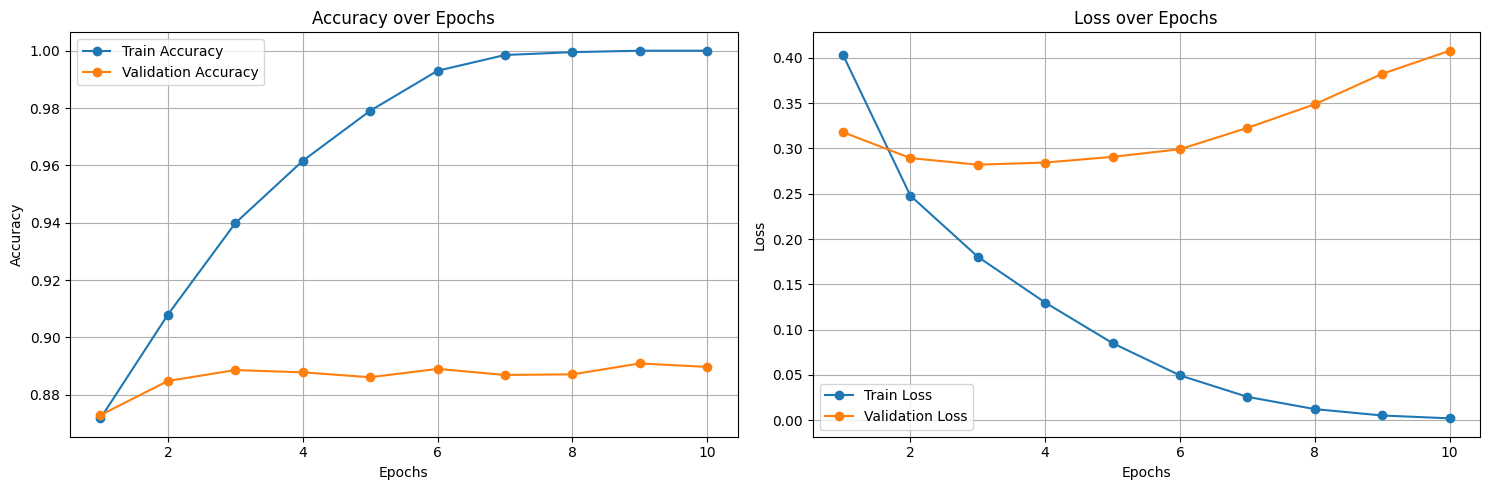

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
axes[0].plot(range(1, num_epochs + 1), eval_accs, label="Validation Accuracy", marker='o')
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid()

axes[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
axes[1].plot(range(1, num_epochs + 1), eval_losses, label="Validation Loss", marker='o')
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [31]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_acc, test_loss = evaluate(model, criterion, device, test_dataloader)
test_acc, test_loss

(0.8958, 0.3620750887107246)

### **Evaluation & Prediction**

In [32]:
tokenizr = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=2
    ).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model


def inference(sentence, vocabulary, model):
    # Preprocess the input sentence (e.g., lowercasing, removing punctuation)
    sentence = preprocess_text(sentence)

    # Tokenize the sentence and convert tokens to indices using the vocabulary
    encoded_sentence = vocabulary(tokenizer(sentence))

    # Convert the list of indices to a tensor
    encoded_sentence = torch.tensor(encoded_sentence).to(device)

    # Add an extra dimension (batch dimension) to the tensor
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        # Get model predictions for the encoded sentence
        predictions = model(encoded_sentence)

    # Apply the Softmax function to convert logits to probabilities
    preds = nn.Softmax(dim=1)(predictions)

     # Get the predicted class with the highest probability
    p_max, y_hat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, y_hat.item()

In [34]:
test_sentence = test_df['preprocess_sentence'][5999]
test_df.iloc[5999]

sentence               Ghé tiệm mua mấy cái bánh_bao mà thấy bánh làm...
label                                                                  1
preprocess_sentence    ghé tiệm mua mấy cái bánh bao mà thấy bánh làm...
Name: 5999, dtype: object

In [35]:
model = load_model("./models/text_cnn_model.pth")
preds = inference(test_sentence, vocabulary, model)
preds

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(98.0, 1)